## Polynomial Regression Challenge

In [2]:
from functions import *
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Below, we will generate some synthetic data for this challenge

We have 2 continuous features, `x1` and `x2`, and a binary target `y`

In [3]:
data = generate_data(random_seed= 42)
df = pd.DataFrame(data = data, columns = ['x1', 'x2', 'y'])
print(df.shape)
df.head(3)

(1000, 3)


,x1,x2,y
0,-0.597098,0.896927,1.0
1,0.523172,-0.129884,1.0
2,-0.183970,-1.281665,0.0


<Axes: xlabel='x1', ylabel='x2'>

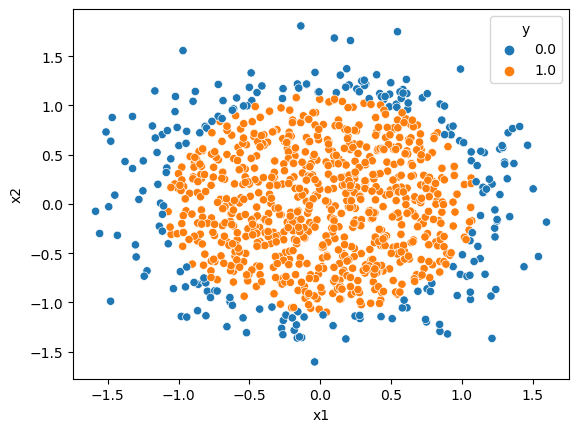

In [4]:
sns.scatterplot(x = df['x1'], y = df['x2'], hue = df['y'])

This is a binary classification problem, so we need to use an appropriate algorithm, like logistic regression. 

Looking at our data, we can see that there does appear to be a clearly defined boundary between the classes (they're not mixed up together).

However, this boundary is clearly not linear, so a basic logistic regression won't work -- we'll need to introduce polynomial features to capture this trend!

>*Note*: There are non-linear models you will encounter soon that could capture this boundary without polynomial features (i.e. a tree based model), but for now we will focus on logistic regression

### Task 1: Data Exploration

We've already looked at the relationship between the features and the target in the visualization above, but lets do some basic QA to ensure our data is suitable for modelling.

1. Look at the descriptive statistics (mean, std dev, quantiles, min, max, etc) for the variables at the target    

In [5]:
# Get descriptive statistics for all columns
print(df.describe())

                x1           x2            y
count  1000.000000  1000.000000  1000.000000
mean      0.021836     0.011643     0.773000
std       0.629175     0.636919     0.419102
min      -1.586814    -1.603269     0.000000
25%      -0.464612    -0.488465     1.000000
50%       0.045429     0.014262     1.000000
75%       0.499372     0.506822     1.000000
max       1.598469     1.806975     1.000000


2. Check if there are any missing values

In [6]:
# Check for missing values in all columns
print(df.isnull().sum())

x1    0
x2    0
y     0
dtype: int64


3. Do some more EDA visualization:
    - Visualize the distribution of each variable (i.e. a histogram for continuous features, a bar plot for the target)
    - Try creating an overlapped histogram of the features to compare their histograms (hint: create two seaborn plots in the same cell, use the `alpha` parameter for transparency)

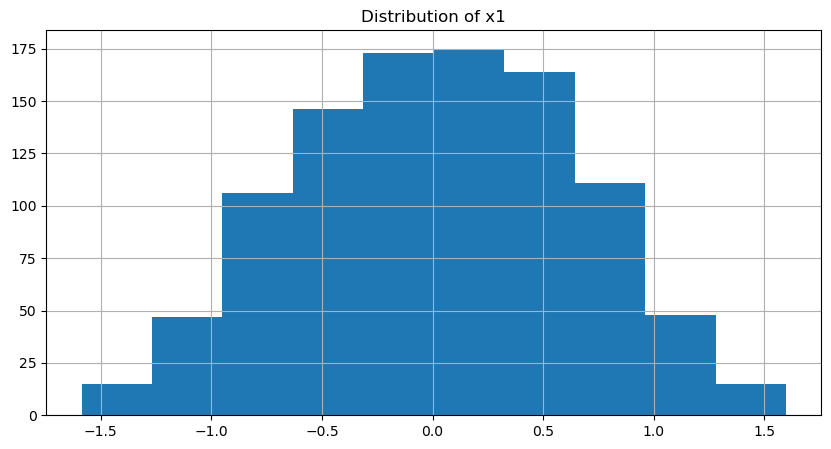

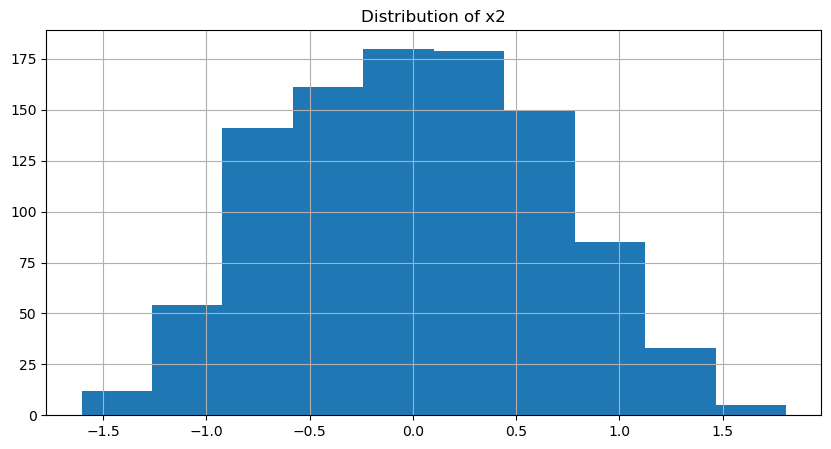

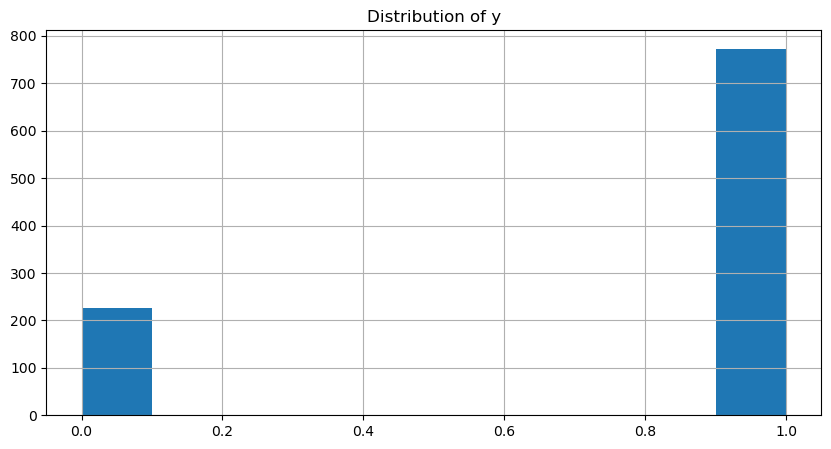

In [6]:
# Visualize the distribution of each variable
for column in df.columns:
    plt.figure(figsize=(10, 5))
    if df[column].dtype == 'object':
        # If the column is categorical, use a bar plot
        sns.scatterplot(df[column])
    else:
        # If the column is numerical, use a histogram
        df[column].hist()
    plt.title(f'Distribution of {column}')
    plt.show()

4. Look at the histograms of x1 and x2
    - Do these look like a familiar distribution? Can you perform a statistical test to check? Assume $\alpha = 0.05$

c:\Users\16476\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\16476\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


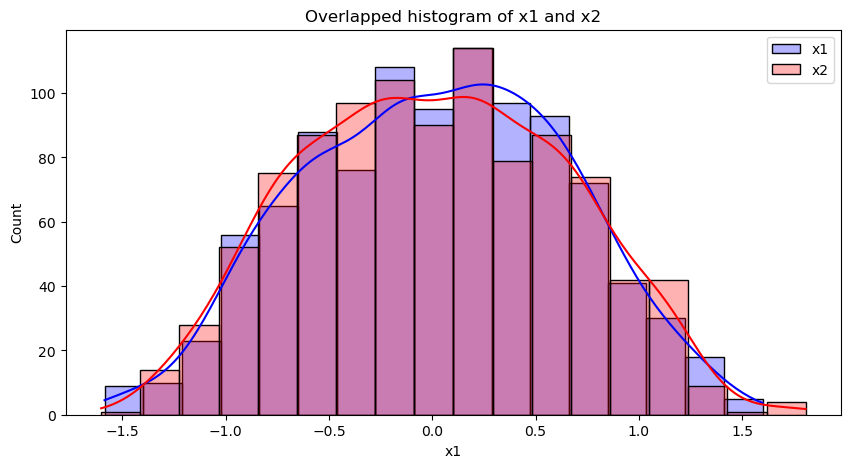

In [5]:
# Overlapped histogram of the features
plt.figure(figsize=(10, 5))
sns.histplot(df['x1'], color='blue', kde=True, alpha=0.3, label='x1')
sns.histplot(df['x2'], color='red', kde=True, alpha=0.3, label='x2')
plt.title('Overlapped histogram of x1 and x2')
plt.legend()
plt.show()

> Think ahead to your ML modelling:
> Do you think feature scaling is a necessary step here? What is the purpose of feature scaling? Make a decision whether or not to include it in your modelling

Feature scaling is a preprocessing step that often improves the performance of machine learning algorithms. It standardizes or normalizes the range of independent variables or features of the data, which can be important in many machine learning algorithms.

The purpose of feature scaling is to make sure that all features have a similar scale so that no feature dominates others when a model is learning from the data. This is particularly important for algorithms that use a distance measure, like k-nearest neighbors (KNN) and support vector machines (SVM), or that use gradient descent to optimize the model parameters, like linear regression, logistic regression, and neural networks.

In the case of logistic regression, feature scaling can help the model converge more quickly to the optimal solution during training. However, logistic regression doesn't necessarily require feature scaling to work correctly, as it's not sensitive to the range of the input features.

So, whether to include feature scaling in your modelling or not depends on the specific characteristics of your data and the model you're using. If your features have vastly different scales or ranges, it might be beneficial to use feature scaling. If the scales are already similar, it might not make a big difference.

In conclusion, it's often a good idea to try both with and without feature scaling and see which gives better results for your specific case.

### Task 2: Modelling 

1. Perform a train test split on the data 
    - Remember that higher order polynomials will almost always have lower training error due to overfitting
    - We will use evaluation on the test set to decide the best model fit

In [8]:
from sklearn.model_selection import train_test_split

# Define the features and the target
X = df[['x1', 'x2']]
y = df['y']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

2. Select an evaluation criterion
    - Our target is imbalanced, is it appropriate to use accuracy?
    - We want an overall good fit, not biased towards false positives or false negatives. Are recall/ precision appropriate?
    - What about one of the 'balanced' criteria for imbalanced data sets?

When dealing with imbalanced datasets, accuracy is not a good metric because it can be misleading. Models could simply predict the majority class in all instances and achieve a high accuracy rate.

Precision and recall are more useful than accuracy in such cases. However, if I want an overall good fit not biased towards false positives or false negatives, I might want to consider the F1 score, which is the harmonic mean of precision and recall.

Another good metric for imbalanced datasets is the Area Under the Receiver Operating Characteristic Curve (AUC-ROC). It tells us about the model's ability to distinguish between the classes.

For extremely imbalanced datasets, I might want to consider using metrics that are specifically designed for imbalanced datasets, such as the Balanced Accuracy, the Matthews Correlation Coefficient (MCC), or the Kappa statistic.

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, balanced_accuracy_score
from sklearn.metrics import matthews_corrcoef, cohen_kappa_score

In [10]:
# Assuming y_test are the true labels and y_pred are the predicted labels
y_pred = model.predict(X_test)  # replace 'model' with your actual model

print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred))
print('AUC-ROC:', roc_auc_score(y_test, y_pred))
print('Balanced Accuracy:', balanced_accuracy_score(y_test, y_pred))
print('Matthews Correlation Coefficient:', matthews_corrcoef(y_test, y_pred))
print('Kappa statistic:', cohen_kappa_score(y_test, y_pred))

Accuracy: 0.8
Precision: 0.8
Recall: 1.0
F1 score: 0.8888888888888888
AUC-ROC: 0.5
Balanced Accuracy: 0.5
Matthews Correlation Coefficient: 0.0
Kappa statistic: 0.0


3. Try a simple logistic regression:
    - We don't expect this to work well, because no straight line can create the correct decision boundary 
    - This will act as our baseline

In [13]:
from sklearn.linear_model import LogisticRegression

# Create a logistic regression model
model = LogisticRegression()

# Fit the model
model.fit(X_train, y_train)

# Compute the metrics
y_pred = model.predict(X_test)
f1 = f1_score(y_test, y_pred)
print('Without feature scaling:')
print('F1 Score:', f1)

Without feature scaling:
F1 Score: 0.8888888888888888


In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Create a pipeline with feature scaling and logistic regression
model = make_pipeline(StandardScaler(), LogisticRegression())

# Fit the model
model.fit(X_train, y_train)

# Compute the metrics
y_pred = model.predict(X_test)
f1 = f1_score(y_test, y_pred)
print('With feature scaling:')
print('F1 Score:', f1)

With feature scaling:
F1 Score: 0.8888888888888888


#### Interpretation: 

The F1 scores for both models (with and without feature scaling) are exactly the same. This means that, in this particular case, feature scaling did not have an impact on the performance of the logistic regression model.

Logistic regression is not distance-based and can converge without feature scaling. However, feature scaling can sometimes help logistic regression converge faster, especially if the features have very different scales. In this case, it seems that the scales of the features were not significantly different, or the logistic regression algorithm was robust enough to handle them without scaling.

It's important to note that the impact of feature scaling can vary depending on the specific dataset and model. While it didn't make a difference in this case, there might be other cases where it does. It's often a good idea to experiment with different preprocessing steps like feature scaling to see what works best for your specific case.

4. Write a function that computes your chosen metric for different degrees of PolynomialFeatures
    - Inputs should be your dataframes, and the maximum polynomial degree
    - For each degree from 1 to your max degree, fit a logistic regression model
        - (HINT: use `for i in range(1, max+1):`)
    - For each degree, print the degree, and the score for your chosen metric
    - The function should return the fitted model with the highest score

In [15]:
from sklearn.metrics import f1_score, balanced_accuracy_score, matthews_corrcoef, cohen_kappa_score

def compute_metrics(X_train, y_train, X_test, y_test, max_degree):
    best_f1_score = 0
    best_degree = 0
    best_model = None

    for i in range(1, max_degree + 1):
        # Create a pipeline with polynomial features and logistic regression
        model = make_pipeline(PolynomialFeatures(degree=i), LogisticRegression())

        # Fit the model
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)

        # Compute the metrics
        f1 = f1_score(y_test, y_pred)
        balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
        mcc = matthews_corrcoef(y_test, y_pred)
        kappa = cohen_kappa_score(y_test, y_pred)

        # Print the degree and the metrics
        print('Degree:', i)
        print('F1 Score:', f1)
        print('Balanced Accuracy:', balanced_accuracy)
        print('Matthews Correlation Coefficient:', mcc)
        print('Kappa statistic:', kappa)
        print('---')

        # If the F1 score is better than the current best F1 score, update the best F1 score, best degree, and best model
        if f1 > best_f1_score:
            best_f1_score = f1
            best_degree = i
            best_model = model

    # Print the best degree and the best F1 score
    print('Best Degree:', best_degree, 'Best F1 Score:', best_f1_score)

    # Return the best model
    return best_model

In [16]:
best_model = compute_metrics(X_train, y_train, X_test, y_test, max_degree=5)

Degree: 1
F1 Score: 0.8888888888888888
Balanced Accuracy: 0.5
Matthews Correlation Coefficient: 0.0
Kappa statistic: 0.0
---
Degree: 2
F1 Score: 0.9937888198757764
Balanced Accuracy: 0.975
Matthews Correlation Coefficient: 0.9686442096757053
Kappa statistic: 0.9681528662420382
---
Degree: 3
F1 Score: 0.9937888198757764
Balanced Accuracy: 0.975
Matthews Correlation Coefficient: 0.9686442096757053
Kappa statistic: 0.9681528662420382
---
Degree: 4
F1 Score: 0.9846153846153847
Balanced Accuracy: 0.9375
Matthews Correlation Coefficient: 0.9211323729436766
Kappa statistic: 0.9180327868852459
---
Degree: 5
F1 Score: 0.9846153846153847
Balanced Accuracy: 0.9375
Matthews Correlation Coefficient: 0.9211323729436766
Kappa statistic: 0.9180327868852459
---
Best Degree: 2 Best F1 Score: 0.9937888198757764


> (STRETCH): There is a more elegant way to do this using sklearn Pipelines, which you will learn later. Optionally, research using pipelines to tune hyperparameters like the degree parameter of PolynomialFeatures. See if you get the same result as your function 

### Task 3: Interpretation

We have created a function for you to visualize the decision boundary created by your model. We already imported it at the top of this notebook.

The function call looks like `plot_boundaries(X, y, degree)`, where X is your features dataframe (i.e. X_train), your target series (i.e. y_train), and degree is the integer of the maximum polynomial degree

1. Experiment with this function with different polynomial degrees
    - What is the smallest degree that seems to effectively capture the decision boundary?
    - Does this match with your findings from the modelling step?

c:\Users\16476\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


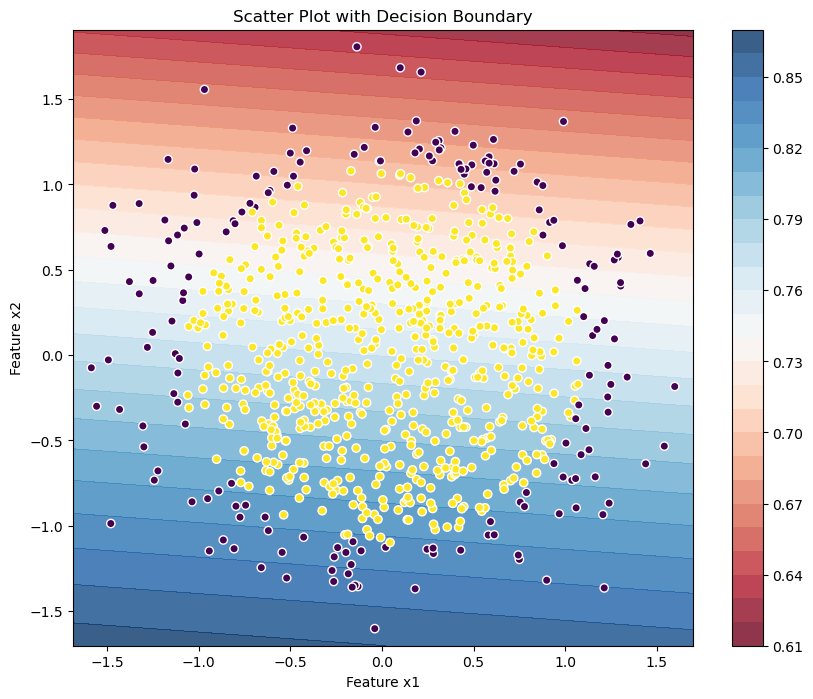

c:\Users\16476\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


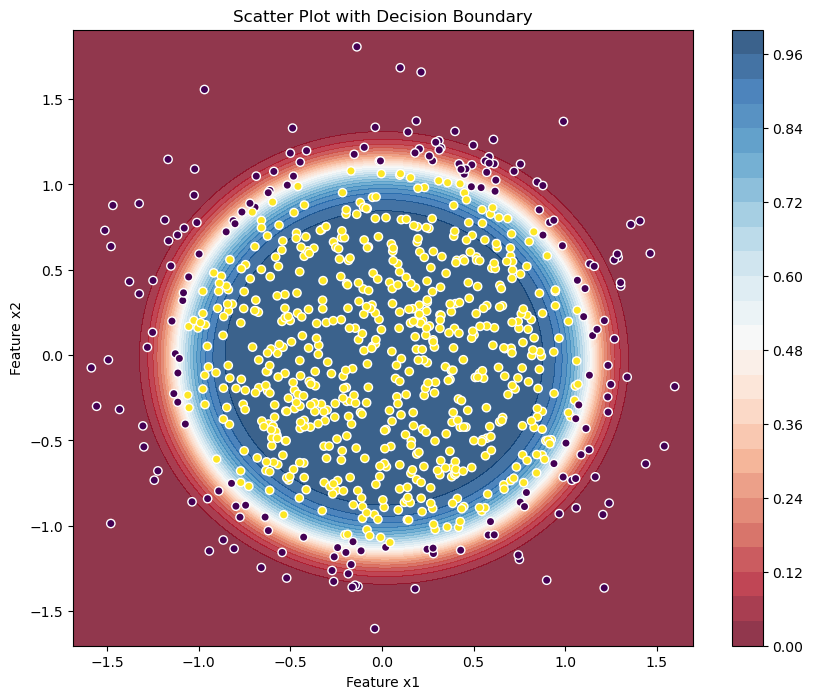

c:\Users\16476\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


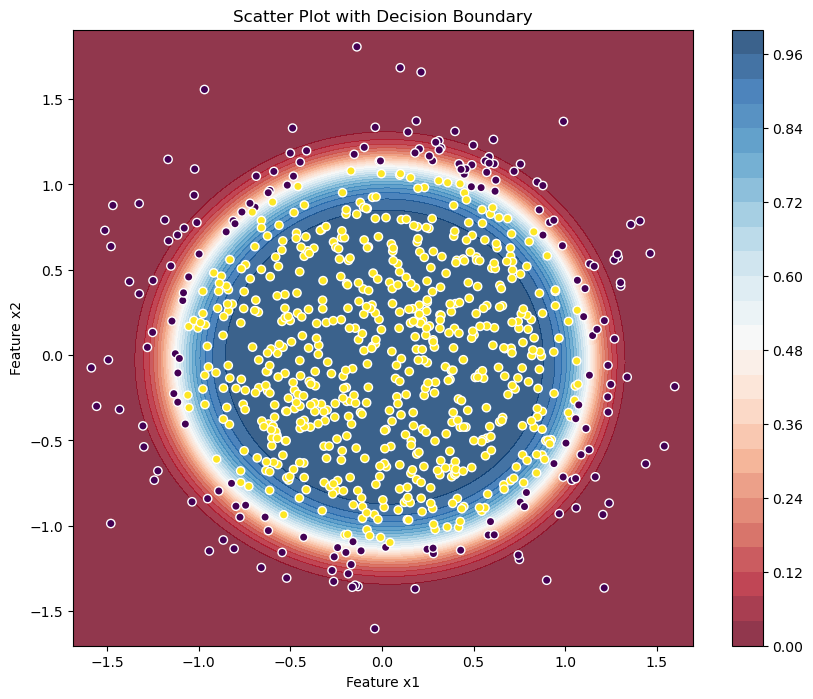

c:\Users\16476\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


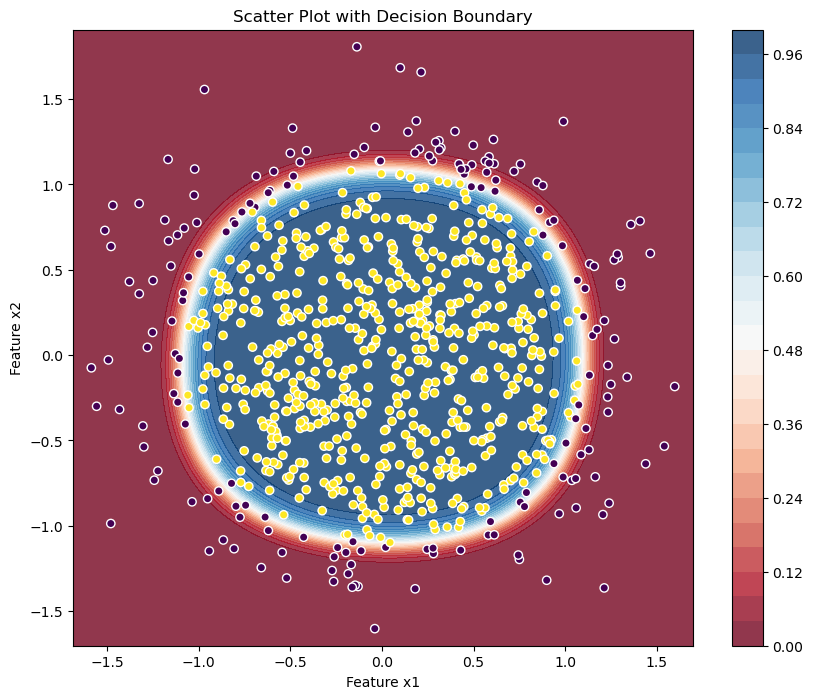

c:\Users\16476\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


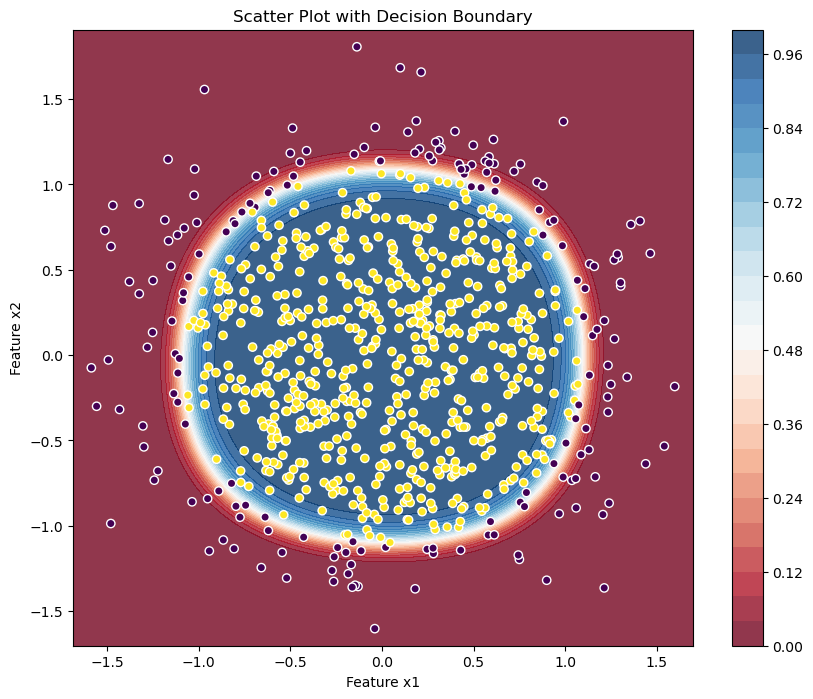

In [17]:
# Define the maximum degree
max_degree = 5

# Loop over each degree from 1 to max_degree
for degree in range(1, max_degree + 1):
    # Call the plot_boundaries function with the current degree
    plot_boundaries(X_train, y_train, degree)

2. Look up the mathematical function to define a circle - we can consider this the underlying 'data generating function'
    - Is this the same degree as your best model fit?
    - Consider, in general, does it make sense to use a higher order polynomial than that which captures the actual physical process?

The mathematical function to define a circle is `(x-h)^2 + (y-k)^2 = r^2`, where `(h,k)` is the center of the circle and `r` is the radius. This is a second degree polynomial equation, as the highest power of the variables `x` and `y` is 2.

To compare this with the best model fit, I can look at the degree of the polynomial that gave the best F1 score in the modelling step. This degree is 2, so it matches the degree of the circle equation.

As for whether it makes sense to use a higher order polynomial than that which captures the actual physical process, it depends on the specific situation. In general, using a higher order polynomial can capture more complex patterns in the data, but it can also lead to overfitting, where the model fits the noise in the training data rather than the underlying trend. This can result in poor performance on new, unseen data.

On the other hand, using a lower order polynomial can lead to underfitting, where the model is too simple to capture the underlying trend in the data.

Therefore, it's often a good idea to try different degrees of polynomials and use cross-validation or a separate validation set to choose the degree that gives the best performance on unseen data.

### Task 4: The Right Tool for the Job

Some models naturally do a better job at some tasks than others. Once we are familiar with more models, we can use our intuition as data scientists to choose the right tool for the job. 

k-Nearest Neighbors Classifier is a very simple model that considers the `k` closest examples to the prediction target in the feature space (by euclidean distance), and takes the 'vote' of these neighboring examples to make a prediction. So if 3 neighbors were class 1 and 2 were class 0, we would predict class 1 (with a probability of $\frac{3}{5}$)

(Note: k-NN can also be a regressor, where the values of the neighboring examples are simply averaged)

Unlike logisitic regression, k-NN does not model any particular mathematical function. It is a [non-parametric model](https://en.wikipedia.org/wiki/Nonparametric_statistics#:~:text=Non%2Dparametric%20models%20differ%20from,and%20not%20fixed%20in%20advance.) without a specified structure, and so can potentially fit complex decision boundaries, despite its simplicity. 

1. Try using our previous plotting function with the added argument `modeltype = 'knn'`. This model is much simpler than engineering polynomial features - does it still capture our decision boundary effectively?

> Note: If you want to investigate more with k-NN there is a `neighbors` argument in the function. By default it is set to 1.
